# 回帰: 燃費を予測する

回帰問題では、離散的なラベル予測とは異なり、連続的な値の出力を予測することが目的となる。

このチュートリアルでは、Auto MPGデータセットを使用して、1970年代後半から1980年代始めの自動車の燃費を予測するモデルを構築する。

In [1]:
# ペアプロットのためにseabornを使用する
# !pip install -q seaborn
# pip installの代わりに事前に以下でインストールしておく
# conda install seaborn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


## データセットの取得

Auto MPGデータセットを取得する。  
https://archive.ics.uci.edu/ml/index.php

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [4]:
# pandasを使ってデータをインポート
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## データのクレンジング
 
 このデータには、いくつか欠損値がある。
 今回のチュートリアルでは簡単化のために、欠損値を含む行を削除する。


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

"Origin"の列は数値ではなくカテゴリーのため、ワンホットエンコーディングを行う。

In [7]:
origin = dataset.pop("Origin")
dataset["USA"] = (origin == 1)*1.0
dataset["Europe"] = (origin == 2)*1.0
dataset["Japan"] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## データを訓練用セットとテスト用セットに分割

In [8]:
# pandasのsampleとdropを活用して分割
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## データの観察
訓練用セットのいくつかの列の組み合わせの同時分布を確認する。

また、全体の統計値も確認する。

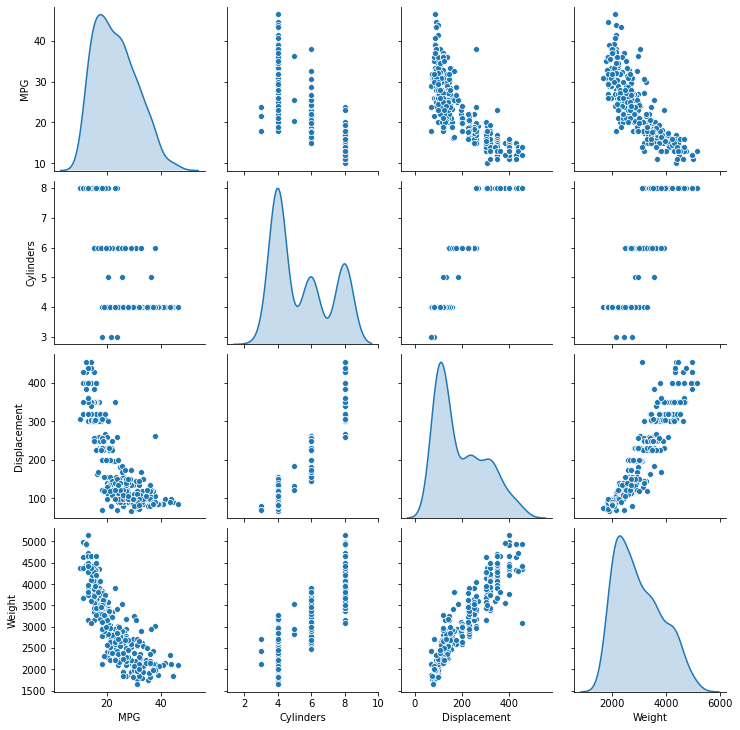

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## ラベルと特徴量の分離

ラベル、すなわち目的変数を特徴量から切り離す。このラベルはモデルに予測させたい数量。

In [11]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

## データの正規化

`train_stats`の結果を見て、各特徴量の範囲がどれほど違っているかに注目する。  
例えば、`mean`の値を確認した時、数値の桁数が全く異なることに着目。こうしたスケールや値の範囲が異なる特徴量を正規化するのは重要である。正規化なしでもモデルは収束する場合もあるが、一般的にはモデルの訓練はより難しくなり、訓練によって得られたモデルも入力で使われる単位に依存することになる (正規化しておけば、kgでもgでも入力ができるようになる)。

正規化に使用する統計量は訓練データセットだけを使って算出しているが、この統計量はテスト用データセットの正規化にも使用する。テスト用のデータセットをモデルの訓練に使用した分布と同じ分布に射影する必要があるため。

In [12]:
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## モデル
### モデルの構築

2つの全結合層の隠れ層と、1つの連続値を返す出力層からなる、`Sequential`モデルを使用する。

後から2つ目のモデルを構築するため、`build_model`という関数の中に組み込む。

In [13]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss="mse",
                  optimizer=optimizer,
                  metrics=["mae", "mse"])
    return model

model = build_model()

### モデルの検証

`.summary`メソッドを使って、モデルの簡単な説明を表示する。
また、訓練用データのうち、10個のサンプルからなるバッチを作成して、それを使って`model.predict`メソッドを呼び出して、予定通りの出力(型および形状)が得られることを確認する。

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.19955707],
       [-0.00167989],
       [ 0.230804  ],
       [ 0.0062433 ],
       [ 0.31414405],
       [-0.02608345],
       [ 0.3500368 ],
       [ 0.0719109 ],
       [ 0.02315474],
       [ 0.59133893]], dtype=float32)

### モデルの訓練

モデルを1000エポック訓練し、訓練と検証の正解率を`history`オブジェクトに記録する。

In [16]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.537794,1.045274,2.537794,9.755294,2.338269,9.755294,995
996,2.361732,0.999211,2.361732,9.499840,2.286860,9.499840,996
997,2.665839,1.089383,2.665838,9.498916,2.298950,9.498915,997
998,2.508271,1.020278,2.508271,9.878554,2.339423,9.878554,998
999,2.837370,1.124952,2.837370,9.475295,2.338111,9.475295,999


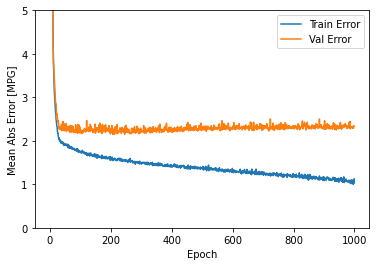

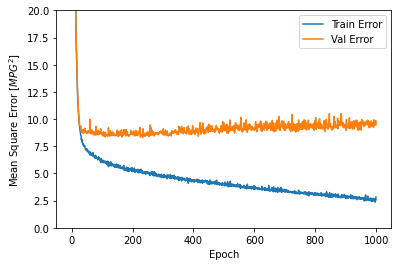

In [18]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

グラフを見ると検証エラーは100エポックを過ぎたあたりで改善が見られなくなり、むしろ悪化している。

検証スコアの改善が見られなくなったら自動的に訓練を停止するように、`model.fit`メソッドの呼び出しを変更する。
今回のチュートリアルでは、エポック毎に訓練状態をチェックするEarlyStoppingコールバックを使用して、設定したエポック数の間に改善が見られない場合、訓練を自動的に停止させる。

このコールバックに関する詳細は以下。  
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=ja


.............................................................

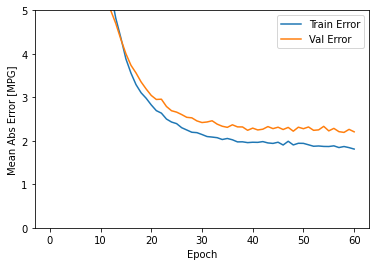

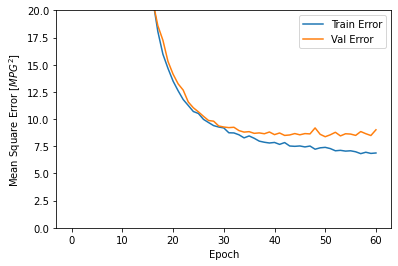

In [19]:
model = build_model()

# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [20]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.9247 - mae: 2.0478 - mse: 6.9247
Testing set Mean Abs Error:  2.05 MPG


### モデルを使った予測

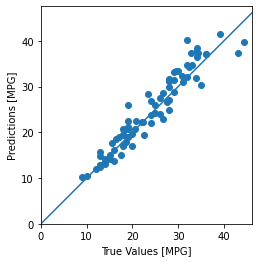

In [21]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


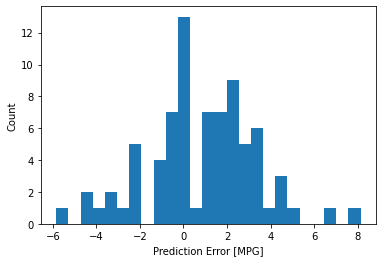

In [22]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [ ]:
## 結論

このチュートリアルでは、回帰問題を扱うためのテクニックをいくつか使用した。
ここではそのまとめを行う。

- 平均二乗誤差(MSE: Mean Squared Error)は回帰問題に使われる一般的な損失関数 (分類問題には異なる損失関数が使われる)
- 平均絶対誤差(MAE: Mean Absolute Error)は回帰問題に使われる一般的な評価指標
- 入力数値特徴量の範囲が異なっている場合、特徴量ごとに同じ範囲に正規化する
- 訓練用データが多くない場合、過学習を避けるために少ない隠れ層をもつ小さいネットワークを使うのが良い方策の1つ
- Early Stoppingは過学習を防止するための便利な手法の1つ